<a href="https://colab.research.google.com/github/ekakurnia/CNN-DeepLearning/blob/master/Tomato_Inception_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd drive/'My Drive'

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


In [0]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [0]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
directory_root = './Dataset/'
width=224
height=224
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [12]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    %time print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Image loading completed
CPU times: user 117 µs, sys: 27 µs, total: 144 µs
Wall time: 148 µs


In [13]:
image_size = len(image_list)
image_size

1200

In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [15]:
print(label_binarizer.classes_)

['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [17]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
# Defining Inception Model

# Impor paket yang diperlukan Model
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate

# Inisialisasi Core
kernel_init = tf.keras.initializers.glorot_uniform()

# Inisialisasi offset
bias_init = tf.keras.initializers.Constant(value=0.2)


# Fungsi yang menghasilkan Modul Inception
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):

    # Konvolusi 1 × 1
    conv_1x1 = Conv2D(filters_1x1,
                      (1, 1),
                      padding='same',
                      activation='relu')(x)
    conv_1x1 = BatchNormalization()(conv_1x1)

    # Konvolusi 1 × 1 untuk reduksi dimensi Konvolusi 3x3
    conv_3x3 = Conv2D(filters_3x3_reduce,
                      (1, 1),
                      padding='same',
                      activation='relu')(x)
    conv_3x3 = BatchNormalization()(conv_3x3)

    # Konvolusi 3x3
    conv_3x3 = Conv2D(filters_3x3,
                      (3, 3),
                      padding='same',
                      activation='relu')(conv_3x3)
    conv_3x3 = BatchNormalization()(conv_3x3)

    # Konvolusi 1 × 1 untuk reduksi dimensi Konvolusi 5x5
    conv_5x5 = Conv2D(filters_5x5_reduce,
                      (1, 1),
                      padding='same',
                      activation='relu')(x)
    conv_5x5 = BatchNormalization()(conv_5x5)

    # Konvolusi 5x5
    conv_5x5 = Conv2D(filters_5x5, (5, 5),
                      padding='same',
                      activation='relu')(conv_5x5)
    conv_5x5 = BatchNormalization()(conv_5x5)

    # Max pooling
    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)

    # Konvolusi 1 × 1 untuk mencerna dimensi maksimum yang dikurangi
    pool_proj = Conv2D(filters_pool_proj,
                       (1, 1),
                       padding='same',
                       activation='relu')(pool_proj)
    pool_proj = BatchNormalization()(pool_proj)

    # Stack merge
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

    return output

In [20]:
# Impor paket yang diperlukan
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


# Mendefinisikan GoogleNet / Inception-V1
class GoogleNet:
    @staticmethod
    def build(width, height, channel, classes):

        input_layer = Input(shape=(width, height, channel))

        # Inisialisasi inti
        kernel_init = tf.keras.initializers.glorot_uniform()

        # Inisialisasi offset
        bias_init = tf.keras.initializers.Constant(value=0.2)

        # Konvolusi
        x = Conv2D(64,
                   (7, 7),
                   padding='same',
                   strides=(2, 2),
                   activation='relu',
                   name='conv_1_7x7/2')(input_layer)
        x = BatchNormalization()(x)

        # Max pooling
        x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)

        # Konvolusi
        x = Conv2D(64,
                   (1, 1),
                   padding='same',
                   strides=(1, 1),
                   activation='relu',
                   name='conv_2a_3x3/1')(x)
        x = BatchNormalization()(x)

        # Konvolusi
        x = Conv2D(192,
                   (3, 3),
                   padding='same',
                   strides=(1, 1),
                   activation='relu',
                   name='conv_2b_3x3/1')(x)
        x = BatchNormalization()(x)

        # Max pooling
        x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

        # Inception Module
        x = inception_module(x,
                             filters_1x1=64,
                             filters_3x3_reduce=96,
                             filters_3x3=128,
                             filters_5x5_reduce=16,
                             filters_5x5=32,
                             filters_pool_proj=32,
                             name='inception_3a')

        # Inception Module
        x = inception_module(x,
                             filters_1x1=128,
                             filters_3x3_reduce=128,
                             filters_3x3=192,
                             filters_5x5_reduce=32,
                             filters_5x5=96,
                             filters_pool_proj=64,
                             name='inception_3b')

        # Max pooling
        x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

        # Inception Module
        x = inception_module(x,
                             filters_1x1=192,
                             filters_3x3_reduce=96,
                             filters_3x3=208,
                             filters_5x5_reduce=16,
                             filters_5x5=48,
                             filters_pool_proj=64,
                             name='inception_4a')

        # Inception Module
        x = inception_module(x,
                             filters_1x1=160,
                             filters_3x3_reduce=112,
                             filters_3x3=224,
                             filters_5x5_reduce=24,
                             filters_5x5=64,
                             filters_pool_proj=64,
                             name='inception_4b')

        # Inception Module
        x = inception_module(x,
                             filters_1x1=128,
                             filters_3x3_reduce=128,
                             filters_3x3=256,
                             filters_5x5_reduce=24,
                             filters_5x5=64,
                             filters_pool_proj=64,
                             name='inception_4c')

        # Inception Module
        x = inception_module(x,
                             filters_1x1=112,
                             filters_3x3_reduce=144,
                             filters_3x3=288,
                             filters_5x5_reduce=32,
                             filters_5x5=64,
                             filters_pool_proj=64,
                             name='inception_4d')

        # Inception Module
        x = inception_module(x,
                             filters_1x1=256,
                             filters_3x3_reduce=160,
                             filters_3x3=320,
                             filters_5x5_reduce=32,
                             filters_5x5=128,
                             filters_pool_proj=128,
                             name='inception_4e')

        # Max pooling
        x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

        # Inception Module
        x = inception_module(x,
                             filters_1x1=256,
                             filters_3x3_reduce=160,
                             filters_3x3=320,
                             filters_5x5_reduce=32,
                             filters_5x5=128,
                             filters_pool_proj=128,
                             name='inception_5a')

        # Inception Module
        x = inception_module(x,
                             filters_1x1=384,
                             filters_3x3_reduce=192,
                             filters_3x3=384,
                             filters_5x5_reduce=48,
                             filters_5x5=128,
                             filters_pool_proj=128,
                             name='inception_5b')

        # Global Avarage Pooling
        x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

        # Random inactivation
        x = Dropout(0.40)(x)

        # Full connection/output
        x = Dense(classes, activation='softmax', name='output')(x)

        # Create GoogleNet model
        # return Model(input_layer, [x, x1, x2], name='inception_v1')
        return Model(input_layer, x, name='inception_v1')


# Test GoogleNet class instantiation and output summary information of GoogleNet model
if __name__ == "__main__":
    model = GoogleNet.build(width=224, height=224, channel=3, classes=6)
    print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           batch_normalization[0][0]        
______

In [0]:
from tensorflow.keras.optimizers import SGD, Adam, Adamax
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

In [0]:
model.compile(loss="binary_crossentropy", optimizer='Adam',metrics=["accuracy"])

In [23]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    validation_steps=1200// BS,
    max_queue_size=BS*2,
    verbose=1
    )

Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
30/30 [==============================] - 25s 831ms/step - loss: 0.4863 - acc: 0.8405 - val_loss: 0.4546 - val_acc: 0.8333
Epoch 2/50
30/30 [==============================] - 10s 320ms/step - loss: 0.3315 - acc: 0.8745 - val_loss: 0.6808 - val_acc: 0.7597
Epoch 3/50
30/30 [==============================] - 11s 355ms/step - loss: 0.2605 - acc: 0.9003 - val_loss: 1.0637 - val_acc: 0.7271
Epoch 4/50
30/30 [==============================] - 11s 357ms/step - loss: 0.2379 - acc: 0.9071 - val_loss: 1.2835 - val_acc: 0.7229
Epoch 5/50
30/30 [==============================] - 11s 355ms/step - loss: 0.1856 - acc: 0.9300 - val_loss: 1.3387 - val_acc: 0.7236
Epoch 6/50
30/30 [==============================] - 11s 359ms/step - loss: 0.2083 - acc: 0.9219 - val_loss: 1.5681 - val_acc: 0.7222
Epoch 7/50
30/30 [==============================] - 11s 358ms/step - loss: 0.1744 - acc: 0.9311 - val_loss: 

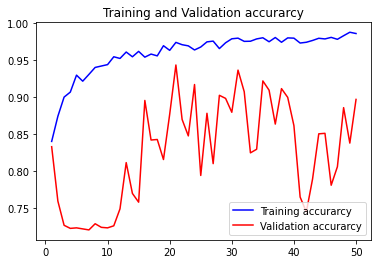

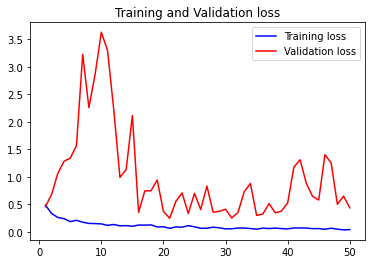

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [25]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
240/240 [==============================] - 0s 2ms/sample - loss: 0.4317 - acc: 0.8972
Test Accuracy: 89.72222208976746
